In [81]:
import pandas as pd
import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data='../data/'
epic_man='https://support.illumina.com/content/dam/illumina-support/documents/downloads/productfiles/mouse-methylation/MouseMethylation-12v1-0_A1_Annotation_Mus_musculus.csv'
#epic=pd.read_csv(epic_man,index_col=0,skiprows=7)

In [168]:
df=pd.read_csv(data+'meth.csv',index_col=0).T
df.shape

(144, 37554)

In [170]:
hor=pd.read_csv(data+'HorvathMammal40.Manifest.May2020.manifest.csv',index_col=0)
df=df[hor[hor.CHR!='chrX'].index.intersection(df.columns)]

In [171]:
v=df.var()>.01
df=df[v[v].index]
df.shape

(144, 8763)

In [173]:
x = StandardScaler().fit_transform(df)
print(x.shape)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
dg = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
dg.index=df.index

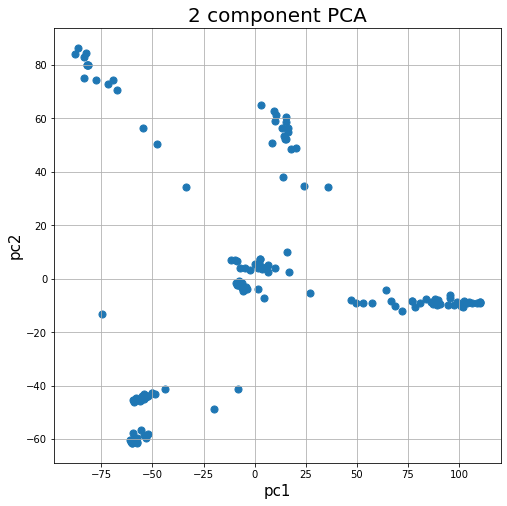

In [174]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc1', fontsize = 15)
ax.set_ylabel('pc2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(dg.loc[:, 'pc1']
            , dg.loc[:, 'pc2']
               , s = 50)
ax.grid()

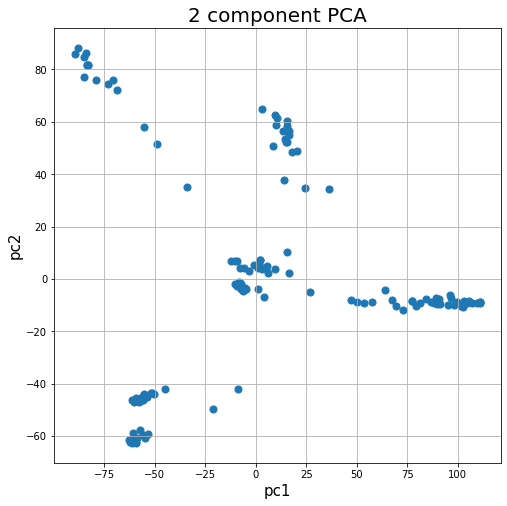

In [175]:
df=df.drop('205128010048_R04C01')
x = StandardScaler().fit_transform(df)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
dg = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
dg.index=df.index
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc1', fontsize = 15)
ax.set_ylabel('pc2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(dg.loc[:, 'pc1']
            , dg.loc[:, 'pc2']
               , s = 50)
ax.grid()

In [176]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(x)
embedding.shape

(143, 2)

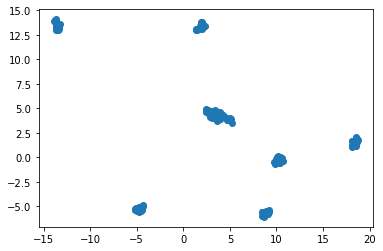

In [177]:
plt.scatter(embedding[:, 0], embedding[:, 1])

In [178]:
labels = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=5,
).fit_predict(embedding)

In [179]:
dg['cluster']=labels

In [180]:
clustered = (labels >= 0)

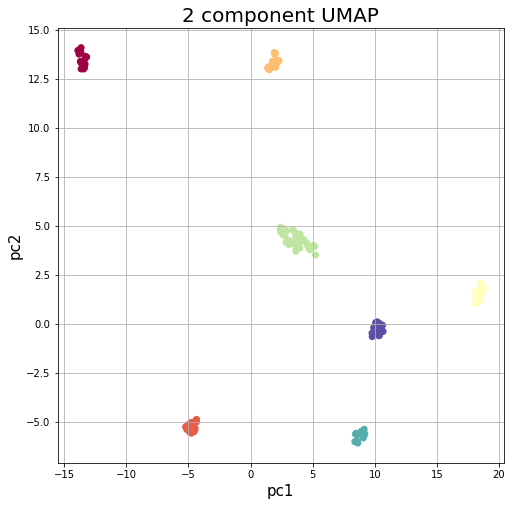

In [181]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc1', fontsize = 15)
ax.set_ylabel('pc2', fontsize = 15)
ax.set_title('2 component UMAP', fontsize = 20)
ax.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=labels[clustered],
            cmap='Spectral');
ax.grid()

In [182]:
dg.cluster.value_counts()

4    37
0    18
1    18
2    18
3    18
6    18
5    16
Name: cluster, dtype: int64

In [183]:
dg.to_csv(data+'clusters.csv')

In [192]:
meta=pd.read_csv(data+'SampleSheetMinimal84.csv',index_col=1)
meta['g']=meta.ExternalSampleID.str[0].astype(int)
meta['m']=meta.ExternalSampleID.str[2].astype(int)
meta['t']=meta.ExternalSampleID.str[-2:]
meta.t.value_counts()

_S    36
_H    18
_P    18
Li    18
Lu    18
_B    18
_K    18
Name: t, dtype: int64

In [193]:
meta=meta[meta.g==1&(meta.t=='_B')]

In [194]:
meta['d']=meta.m.replace({1:'n',2:'n',3:'n',4:'p',5:'p',6:'p'})

In [195]:
df1=df.merge(meta[['d','t']][meta.g==1],left_index=True,right_index=True)
df2=df.merge(meta[['d','t']][meta.g==2],left_index=True,right_index=True)
df3=df.merge(meta[['d','t']][meta.g==3],left_index=True,right_index=True)

In [200]:
dg=df1.groupby('d').mean().T

<AxesSubplot:>

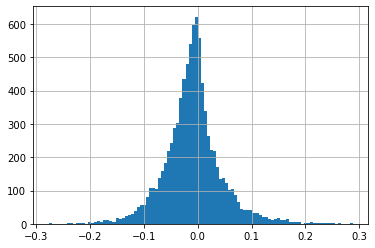

In [201]:
dg['d']=dg['p']-dg['n']
dg.d.hist(bins=100)

In [202]:
dg=dg[dg.d<-.1]
dg.shape

(364, 3)

In [203]:
dg=hor.loc[dg.index]
dg.CHR.value_counts()

chr2     43
chr1     35
chr17    34
chr7     32
chr9     25
chr12    24
chr5     22
chr14    18
chr11    18
chr10    15
chr4     14
chr15    12
chr6     12
chr16    11
chr19     9
chr18     9
chr22     7
chr3      7
chr20     6
chr8      6
chr21     3
chr13     2
Name: CHR, dtype: int64

In [204]:
dgh=df1[dg.index].T

In [205]:
#dgh.columns=['n1','n2','n3','p1','p2','p3']
dgh.to_csv(data+'meth_P.csv')

ValueError: Length mismatch: Expected axis has 5 elements, new values have 6 elements

In [206]:
dgh=hor.loc[dg.index][['HG38.seqnames','HG38.start','HG38.end','HG38.strand']]
dgh['HG38.start']=dgh['HG38.start'].astype(int)
dgh['HG38.end']=dgh['HG38.end'].astype(int)
dgh.reset_index(inplace=True,drop=True)
dgh.to_csv('dmh.txt',sep='\t')
dgh.shape

(364, 4)